In [1]:
import geopandas as gpd
import json
from rtree.index import Index as RTreeIndex
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.geometry import Point
import shapely
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as npm
import osmnx as ox
import pandas as pd
from shapely.ops import snap
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [80]:
def peek(df):
    print(len(df))
    display(df.iloc[0:3, :])

In [4]:
road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/ny.graphml')

In [57]:
line_gdf = gpd.read_file(f'{EXPORTS_DIR}/geojson/' +
                                'example_line_string.geojson')
line = line_gdf.loc[0, 'geometry']

In [311]:
def plot(road_mg,
         line_segments_gdf=None,
         edge_colors='#ff0033',
         figsize=(40, 40)):
    # Determine bounding box for plotting.
    bbox_west = min([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_east = max([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_north = max([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox_south = min([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox = (bbox_north, bbox_south, bbox_east, bbox_west)

    # Plot all collected routes to visualize network coverage.
    fig, ax = plt.subplots(figsize=figsize)
    ox.plot_graph(road_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color='#3a3a3a',
                  bbox=bbox)

    line_segments_gdf.plot(ax=ax, color=[(float(c)*0.2+0.2, float(c)*0.2+0.2, float(c)*0.5+0.5) for c in line_segments_gdf['color']], linewidth=15)

    ax.set_facecolor('#444')
    plt.show()

In [312]:
#one_segment_gdf = gpd.GeoDataFrame(geometry=[line], crs=CRS)
#one_segment_gdf['color'] = '#ff0099'
#plot(road_mg, one_segment_gdf)

In [313]:
def cut(line, distance):
    # Credit: From Shapely User Manual.
    
    # Return copy of line if distance will not segment it.
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    
    coords = list(line.coords)
    
    # Iterate through each coordinate in LineString.
    for i, coord in enumerate(coords):
        coord_distance = line.project(Point(coord))
        
        # The desired distance is exactly at this coordinate; segment here.
        if coord_distance == distance:
            return [LineString(coords[:i + 1]), LineString(coords[i:])]
        
        # The desired distance is at a point between this coordinate and the
        # last one. Create a new coordinate at the desired distance then
        # segment there.
        if coord_distance > distance:
            split_point = line.interpolate(distance)
            
            return [
                LineString(coords[:i] + [(split_point.x, split_point.y)]),
                LineString([(split_point.x, split_point.y)] + coords[i:])
            ]

In [314]:
def color_segments_gdf(segments_gdf):
    for i in range(len(segments_gdf)):
        segments_gdf.loc[i, 'color'] = str(segments_gdf.loc[i, 'start_value'])
        segments_gdf.loc[i, 'start_color'] = str(segments_gdf.loc[i, 'start_value'])
        segments_gdf.loc[i, 'end_color'] = str(segments_gdf.loc[i, 'end_value'])

In [315]:
def segment_equally(line, n_segments=10):
    segments = []
    current_line = LineString(line)
    for i in range(n_segments - 1):
        split_segments = cut(current_line, line.length / n_segments)
        segments.append(split_segments[0])
        current_line = split_segments[1]
    segments.append(current_line)
    segments_gdf = gpd.GeoDataFrame(geometry=segments, crs=CRS)
    return segments_gdf

In [316]:
#ten_segments_gdf = segment_equally(line)
#color_segments_gdf(ten_segments_gdf)
#plot(road_mg, ten_segments_gdf)

In [317]:
def segment_by_distances(line, distances=[], values=[]):
    segments = []
    start_values = []
    end_values = []
    
    current_line = LineString(line)
    
    for i in range(1, len(distances)):
        curr_distance = distances[i]
        prev_distance = distances[i - 1]
        segment_distance = curr_distance - prev_distance

        split_segments = cut(current_line, segment_distance)
        segments.append(split_segments[0])
        if len(split_segments) == 2:
            current_line = split_segments[1]
            
        if len(values) == len(distances):
            start_values.append(values[i - 1])
            end_values.append(values[i])
        
    segments.append(current_line)
    start_values.append(values[-1])
    end_values.append(values[-1])
    
    data = {'start_value': start_values, 'end_value': end_values}
    segments_gdf = gpd.GeoDataFrame(data=data, geometry=segments, crs=CRS)
    
    return segments_gdf

In [318]:
#distanced_segments_gdf = segment_by_distances(
#    line,
#    distances=[0, 0.005, 0.06, 0.08, 0.1, line.length],
#    values=[1, 1, 4, 5, 7, 10])
#display(distanced_segments_gdf)
#color_segments_gdf(distanced_segments_gdf)
#plot(road_mg, distanced_segments_gdf)

In [319]:
def segment_by_coords(line, coords=[]):
    line_coords = [line.coords[0]] + [(c[0], c[1]) for c in coords] + [line.coords[-1]]
    coord_distances = [line.project(Point(coord)) for coord in line_coords]
    coord_values = [coords[0][2]] + [c[2] for c in coords] + [coords[-1][2]]
    return segment_by_distances(line, distances=coord_distances, values=coord_values)

In [320]:
stops_gdf = gpd.read_file(f'{EXPORTS_DIR}/csv/example_stops.csv')
peek(stops_gdf)

56


,lon,lat,geometry
0,-73.955503,40.826647,POINT (-73.95550 40.82665)
1,-73.952145,40.827012,POINT (-73.95215 40.82701)
2,-73.953985,40.825383,POINT (-73.95399 40.82538)


In [350]:
def discretize(gdf, n_segments=2):
    all_segments_gdfs = []
    
    for i in range(len(gdf)):
        segments_gdf = segment_equally(gdf.loc[i, 'geometry'], n_segments)
        values = np.linspace(gdf.loc[i, 'start_value'], gdf.loc[i, 'end_value'], n_segments + 1)
        segments_gdf['start_value'] = values[:n_segments]
        segments_gdf['end_value'] = values[1:]
        all_segments_gdfs.append(segments_gdf)
        
    all_segments_gdf = pd.concat(all_segments_gdfs).drop_duplicates().reset_index()
    return all_segments_gdf

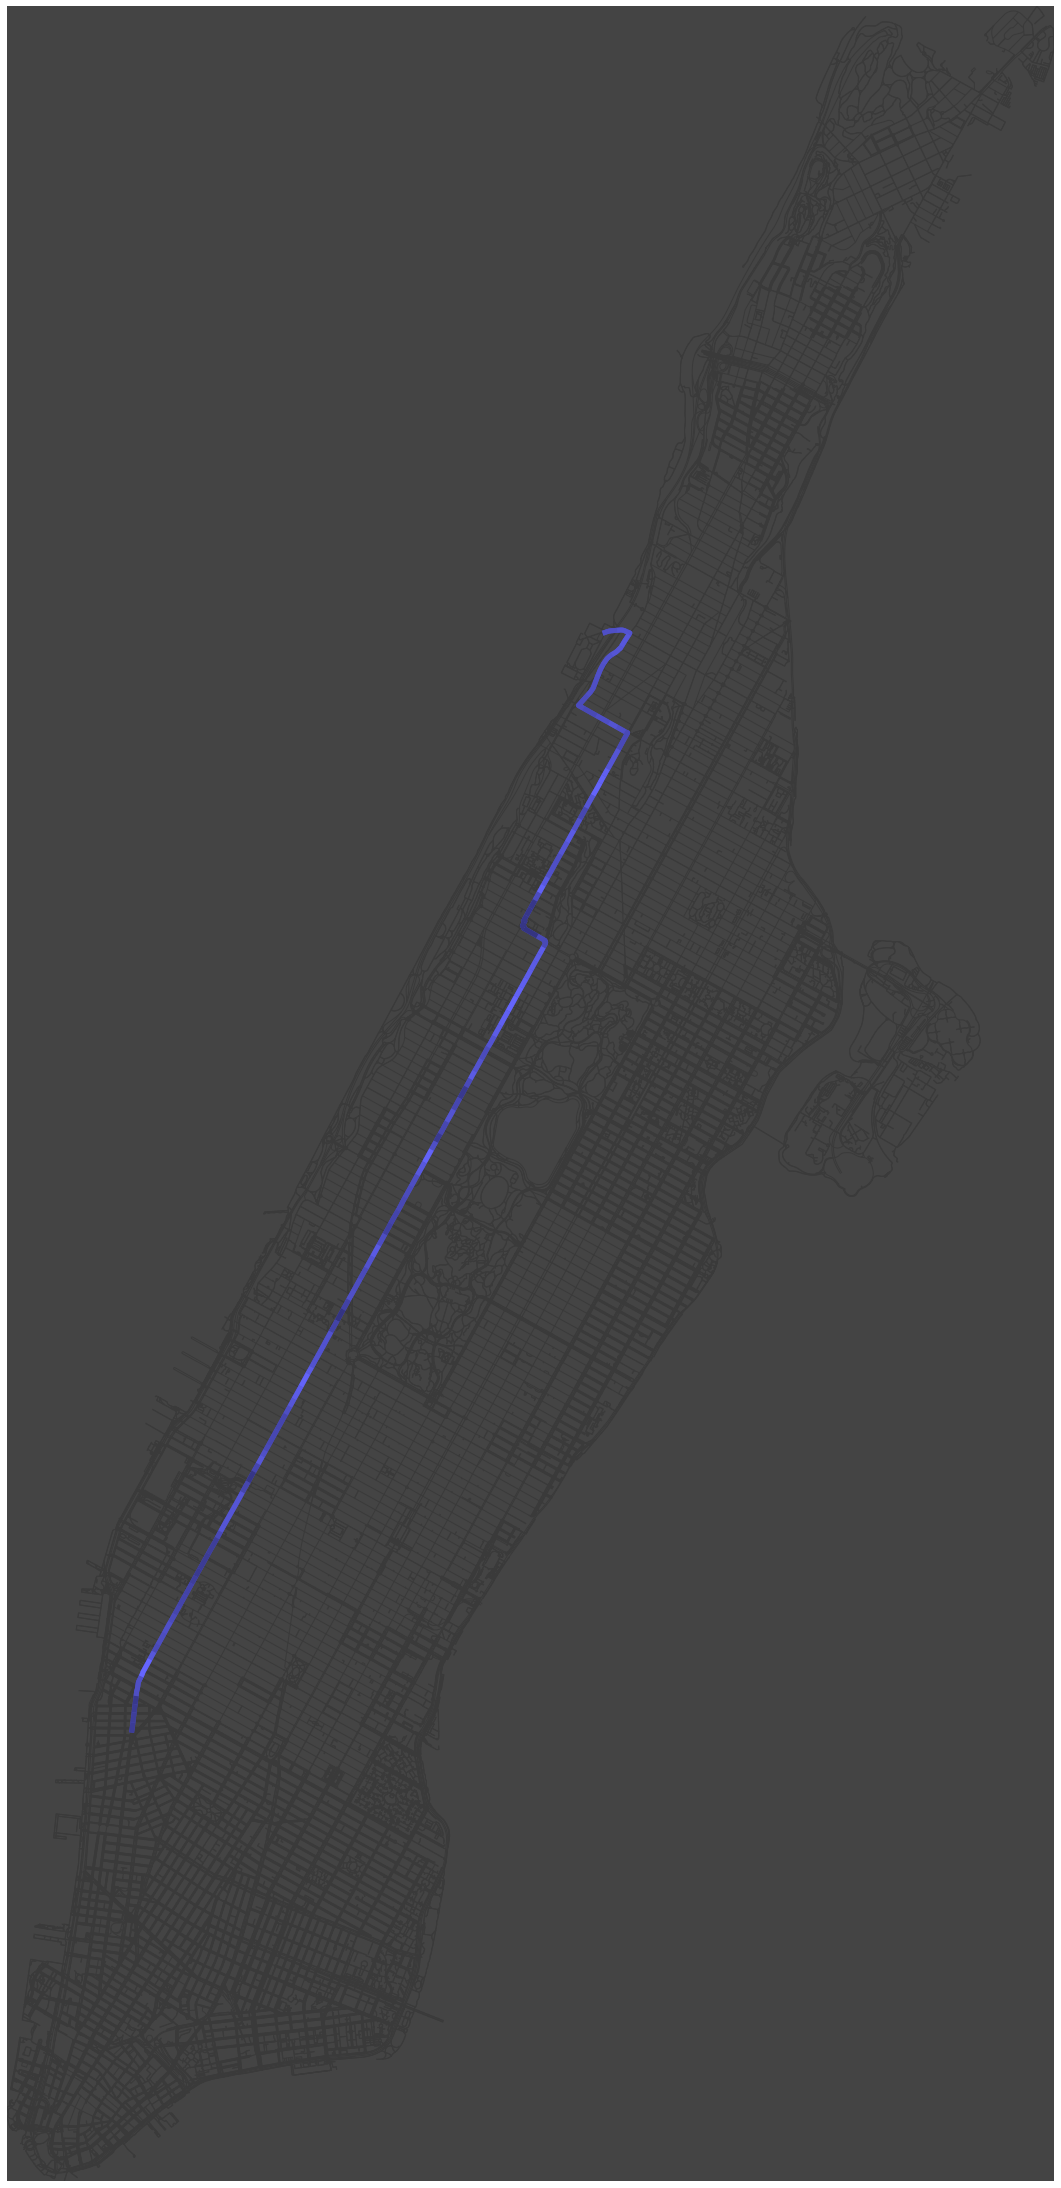

In [351]:
np.random.seed(0)
stop_coords = list(zip(stops_gdf['lon'], stops_gdf['lat'], [np.random.rand() for i in range(len(stops_gdf))]))
stops_segments_gdf = segment_by_coords(line, coords=stop_coords)
stops_segments_gdf = discretize(stops_segments_gdf)
color_segments_gdf(stops_segments_gdf)
plot(road_mg, stops_segments_gdf)